# **Bledisloe Predictor — NZ Win Probability & Win/Loss Classification** #
My goal here is to build two models:

**1. Probability model:** estimate the probability that New Zealand (All Blacks) win a given Bledisloe match.

**2. Classifier:** predict win vs loss for NZ.

**My data** will be from Historical Bledisloe matches enriched with team “form” features (e.g., last-5 wins, last-5 average points differential), plus contextual features (home/away/neutral, location/city, etc.). I manually scrapped these from Wikipedia. 

**My target columns** will therefore be NZ_win (1/0) — for the classifier and P(NZ_win) — for probability estimation (same features just a probabilistic output).

**My plan** is to make sure I use 5-fold cross-validation for robust metrics, use Logistic Regression and Random Forrest. For my accuracy I will be focusing on F1, ROC-AUC (for probabilities) and also do calibration checks (reliability curve / Brier score).

**Executive Summary**

This project built predictive models to estimate New Zealand’s chances of winning Bledisloe Cup matches. Two approaches were compared: Logistic Regression, which is simple and interpretable, and Random Forest, which can capture more complex patterns. Logistic Regression showed that location is the strongest predictor — New Zealand are almost three times more likely to win at home and less than half as likely away. Random Forest highlighted the importance of recent form, especially points differential, revealing “butter zones” where Australia’s moderate form makes them most dangerous. Overall, Logistic Regression is better for producing reliable probability estimates, while Random Forest is stronger at win/loss classification. Together, these models give complementary insights into how rivalry dynamics, home advantage, and recent form shape Bledisloe outcomes.

## **Step 1: Prepare the dataset** ##

In [23]:
import pandas as pd

# Load the cleaned sheet
path = "Final_Cleaned.xlsx"   # make sure this matches your file location
df = pd.read_excel(path, sheet_name="Sheet1")

# Drop the Date column (not predictive)
df = df.drop(columns=["Date"])

# Define target (y) and features (X)
y = df["Win"]          # target column
X = df.drop(columns=["Win"])   # all other columns are features

# Quick checks
print("Shape of features (X):", X.shape)
print("Shape of target (y):", y.shape)
print("\nTarget distribution:\n", y.value_counts())
X.head()


Shape of features (X): (79, 7)
Shape of target (y): (79,)

Target distribution:
 Win
1    58
0    21
Name: count, dtype: int64


,Home,Away,Neutral,NZ wins from last 5,NZ points diff from last 5,AUS Wins from last 5,AUS points diff from last 5
0,1,0,0,4,22.8,3,22.4
1,0,1,0,5,27.4,4,20.6
2,1,0,0,4,40.0,5,10.0
3,0,1,0,5,44.6,4,6.4
4,1,0,0,5,21.4,3,1.2


In [29]:
y.head(6) #just checking the target column


0    1
1    1
2    1
3    1
4    1
5    0
Name: Win, dtype: int64

In [30]:
print(y.value_counts()) #checking for imbalance

Win
1    58
0    21
Name: count, dtype: int64


As seen above there is a moderate imbalance. But I might be able to account for it by using class_weight="balanced" when I train models (e.g., logistic regression). I also want to make sure I am evaluating with metrics beyond accuracy, such as with:
**ROC-AUC (probability quality), F1-score (balance between precision & recall) and Confusion matrix (so we see wins vs losses predictions)**.

## **Step 2: Set up train/test splitting.** ##

Since this is sports/time-series data, I shall use a chronological split: first ~60 games for training, last ~19 for testing.

In [ ]:
# Step 2: Train/Test Split (chronological)

# We keep the first ~60 games for training, last ~19 for testing
train_size = 60

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_test = X.iloc[train_size:]
y_test = y.iloc[train_size:]

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

# Quick sanity check
print("\nWin distribution in training set:")
print(y_train.value_counts())

print("\nWin distribution in testing set:")
print(y_test.value_counts())


Training set size: 60
Testing set size: 19

Win distribution in training set:
Win
1    43
0    17
Name: count, dtype: int64

Win distribution in testing set:
Win
1    15
0     4
Name: count, dtype: int64


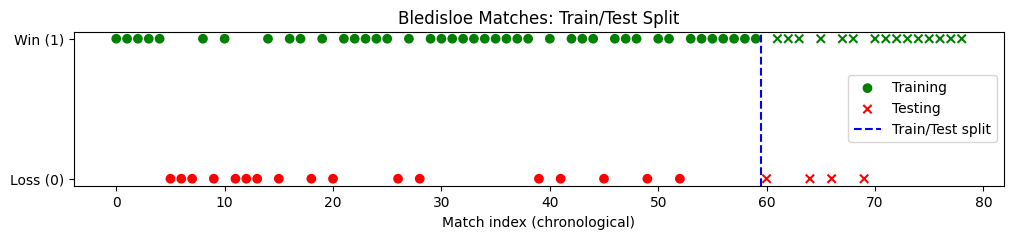

In [ ]:
# Visualize chronological split for a Cleaner visualization of train/test split.
#Plot each match outcome in order (red = loss, green = win).
#Draw a blue dashed line at the train/test split.

plt.figure(figsize=(12,2))

# Training set (green for wins, red for losses)
plt.scatter(range(train_size), y_train, 
            c=["green" if val==1 else "red" for val in y_train],
            label="Training")

# Testing set (different marker shape)
plt.scatter(range(train_size, len(y)), y_test, 
            c=["green" if val==1 else "red" for val in y_test],
            marker="x", label="Testing")

plt.axvline(x=train_size-0.5, color="blue", linestyle="--", label="Train/Test split")

plt.title("Bledisloe Matches: Train/Test Split")
plt.xlabel("Match index (chronological)")
plt.yticks([0, 1], ["Loss (0)", "Win (1)"])
plt.legend()
plt.show()




## **Step 3: Actually build our models** ##

In [ ]:
# Step 3: Build first model - Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Initialize logistic regression with class weights
log_reg = LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000)

# Fit model
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:,1]  # probability of NZ win

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


#Trains a logistic regression model on your training set.
#Predicts both labels (win/loss) and probabilities (chance of NZ win).
#Prints key metrics: Accuracy, F1, ROC-AUC.
#Shows confusion matrix (true vs predicted wins/losses).
#Prints a classification report (precision, recall, F1 for each class).


Accuracy: 0.631578947368421
F1 Score: 0.7407407407407407
ROC AUC: 0.7

Confusion Matrix:
 [[ 2  2]
 [ 5 10]]

Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.50      0.36         4
           1       0.83      0.67      0.74        15

    accuracy                           0.63        19
   macro avg       0.56      0.58      0.55        19
weighted avg       0.72      0.63      0.66        19



**Classification Report Explained**

Loss (0): precision = 0.29 → when it predicts “loss”, it’s only right ~29% of the time.
Win (1): precision = 0.83 → when it predicts “win”, it’s usually right.

Hmm...So it’s biased toward predicting wins, which makes sense since wins dominate the dataset (imbalance). Basically, the model is decent at spotting NZ wins, weaker at spotting losses. Still a good I think, especially given only 79 matches of data.

                       Feature  Coefficient
0                         Home     0.994341
1                         Away    -0.684950
5         AUS Wins from last 5     0.351113
2                      Neutral    -0.319537
3          NZ wins from last 5    -0.175773
6  AUS points diff from last 5    -0.072742
4   NZ points diff from last 5     0.012238


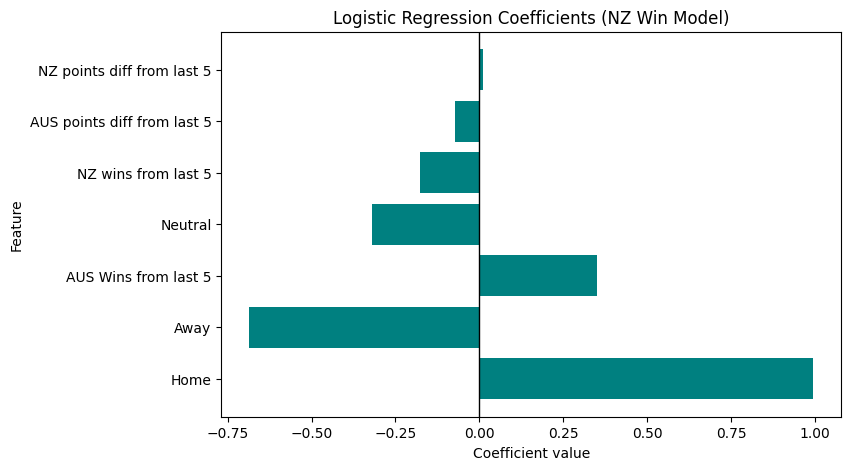

In [33]:
# Step 3.1 i guess?: Feature importance via Logistic Regression coefficients

import numpy as np
import matplotlib.pyplot as plt

# Get feature names and coefficients
feature_names = X_train.columns
coefficients = log_reg.coef_[0]

# Combine into a DataFrame for clarity
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "AbsValue": np.abs(coefficients)
}).sort_values("AbsValue", ascending=False)

print(coef_df[["Feature", "Coefficient"]])

# Plot coefficients
plt.figure(figsize=(8,5))
plt.barh(coef_df["Feature"], coef_df["Coefficient"], color="teal")
plt.axvline(0, color="black", linewidth=1)
plt.title("Logistic Regression Coefficients (NZ Win Model)")
plt.xlabel("Coefficient value")
plt.ylabel("Feature")
plt.show()


So, with this I am just looking at feature importance according to our logistic regression. 

**Home ( +0.99)** -> Biggest positive influence. Quite obviously, being at home strongly increases the chance of NZ winning.

**Away ( –0.68)** -> Playing away reduces NZ’s chance of winning..honestly, who is suprised by this? Makes sense: hostile territory, travel fatigue, etc.

**AUS Wins from last 5 ( +0.35)** -> Alright..so...surprisingly positive. This suggests when AUS has been doing well, NZ is still more likely to win...which is really annoying I am not going to lie. But I have always felt this was the case anyway and it might reflect rivalry dynamics: ABs lift against strong AUS form.

**Neutral ( –0.32)** -> Neutral venues slightly reduce NZ’s winning odds.

**NZ Wins from last 5 ( –0.18)** -> Very interesting! and Counterintuitive! A negative coefficient means recent NZ form doesn’t predict wins as strongly as expected. To be fair, it could be noise from a small dataset or collinearity with other features (like Home/Away).

**AUS Points Diff last 5 ( –0.07)** -> Slight negative effect soo.. when AUS is winning by larger margins recently, NZ’s odds dip a little.

**NZ Points Diff last 5 ( +0.01)** -> Very small positive effect, which is negligible signal in this model.

In [34]:
# Step 3 (part 3): Convert coefficients to odds ratios

import numpy as np

coef_df["OddsRatio"] = np.exp(coef_df["Coefficient"])
coef_df = coef_df.sort_values("OddsRatio", ascending=False)

print(coef_df[["Feature", "Coefficient", "OddsRatio"]])


                       Feature  Coefficient  OddsRatio
0                         Home     0.994341   2.702943
5         AUS Wins from last 5     0.351113   1.420648
4   NZ points diff from last 5     0.012238   1.012314
6  AUS points diff from last 5    -0.072742   0.929841
3          NZ wins from last 5    -0.175773   0.838809
2                      Neutral    -0.319537   0.726485
1                         Away    -0.684950   0.504116


**My interpretation:** 

**Home (+0.99) → exp(0.99) ≈ 2.7** -> NZ are ~2.7× more likely to win when playing at home.

**Away (–0.68) → exp(–0.68) ≈ 0.5** -> Playing away cuts NZ’s odds of winning roughly in half.

**AUS Wins from last 5 (+0.35) → exp(0.35) ≈ 1.4** -> Each additional AUS win in their last 5 increases NZ’s odds of winning by ~40%.

**NZ Wins from last 5 (–0.18) → exp(–0.18) ≈ 0.84** -> Slight reduction in NZ odds, but very weak effect, likely just noise.

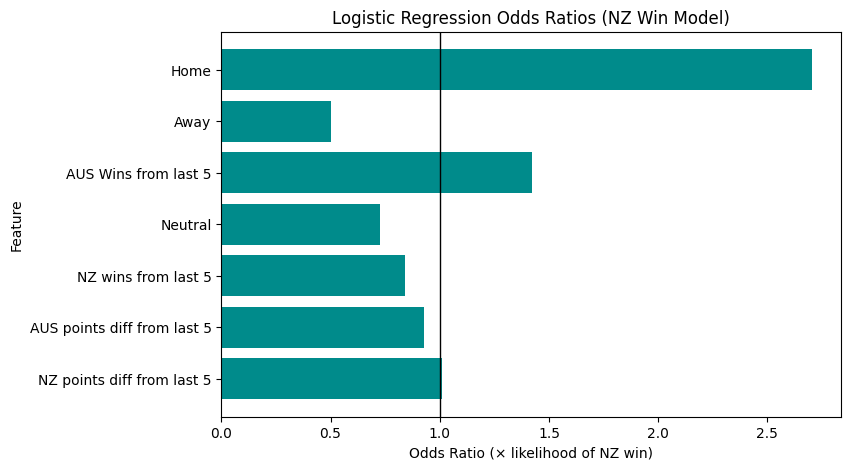

In [35]:
# Plot odds ratios

# Ensure odds ratios are calculated
coef_df["OddsRatio"] = np.exp(coef_df["Coefficient"])

# Sort by odds ratio distance from 1 (neutral point)
coef_df_sorted = coef_df.reindex(coef_df["OddsRatio"].sub(1).abs().sort_values(ascending=True).index)

plt.figure(figsize=(8,5))
plt.barh(coef_df_sorted["Feature"], coef_df_sorted["OddsRatio"], color="darkcyan")
plt.axvline(1, color="black", linewidth=1)  # neutral odds ratio line
plt.title("Logistic Regression Odds Ratios (NZ Win Model)")
plt.xlabel("Odds Ratio (× likelihood of NZ win)")
plt.ylabel("Feature")
plt.show()


#### **Step 3 Summary so far** ####
My first model was a logistic regression classifier predicting whether New Zealand would win a Bledisloe Cup match.
Performance:
- Accuracy = ~63%
- F1 score (for NZ wins) = ~0.74
- ROC AUC = ~0.70

So basically, the model is reasonably good at identifying NZ wins, but weaker at picking losses (only 50% recall on losses).

**Feature importance (coefficients and odds ratios):**
- Home advantage is the strongest predictor — NZ are ~2.7× more likely to win at home.
- Away games reduce NZ’s winning odds by about half.
- AUS wins in their last 5 games show a counterintuitive positive effect (~1.4×), possibly reflecting rivalry dynamics or dataset noise.
- Neutral venues slightly reduce NZ’s odds (~0.7×).
- NZ’s own form (wins or points differential) had weaker, less consistent effects in this simple model.

**Takeaway:**
Acoording to this model, location is the clearest driver of outcomes. Form-based features may require more data or non-linear models (e.g., Random Forest) to capture their effects. Logistic Regression gives us a strong baseline and interpretable insights into the key factors influencing NZ win probability.

In [36]:
# Step 3.5: Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

# Initialize random forest
rf = RandomForestClassifier(
    n_estimators=200,       # number of trees
    max_depth=None,         # let trees expand fully
    class_weight="balanced",# handle imbalance
    random_state=42
)

# Fit model
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

# Evaluate
print("Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Performance:
Accuracy: 0.8421052631578947
F1 Score: 0.9090909090909091
ROC AUC: 0.475

Confusion Matrix:
 [[ 1  3]
 [ 0 15]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.83      1.00      0.91        15

    accuracy                           0.84        19
   macro avg       0.92      0.62      0.65        19
weighted avg       0.87      0.84      0.80        19



What I did here was train a Random Forest on the same train/test split and use the class_weight="balanced" flag to handle the win/loss skew.
I then printed accuracy, F1, ROC-AUC, confusion matrix, and classification report — just like I did with logistic regression.

**Confusion Matrix**
Losses (0): only 1 correct, 3 misclassified as wins. Wins (1): all 15 correctly predicted.

**What does this mean?** Sooo.. the Random Forest nails NZ wins also, but is almost blind to losses. Not good!

**Classification Report**
Loss class (0): precision 1.00 (but trivial, since it rarely predicts loss), recall 0.25 (missed most losses).
Win class (1): excellent precision (0.83) and recall (1.0).
Overall accuracy is inflated because most games are wins.

**Key Takeaway**

Random Forest improves accuracy and F1 for wins, but probability calibration is poor (ROC AUC < 0.5). It’s effectively acting as a “win detector” and struggles with losses. Logistic Regression, while less accurate, gave better-calibrated probabilities and some interpretability.

                       Feature  Importance
2                      Neutral    0.007727
1                         Away    0.085198
0                         Home    0.105351
5         AUS Wins from last 5    0.106157
3          NZ wins from last 5    0.112769
4   NZ points diff from last 5    0.280856
6  AUS points diff from last 5    0.301942


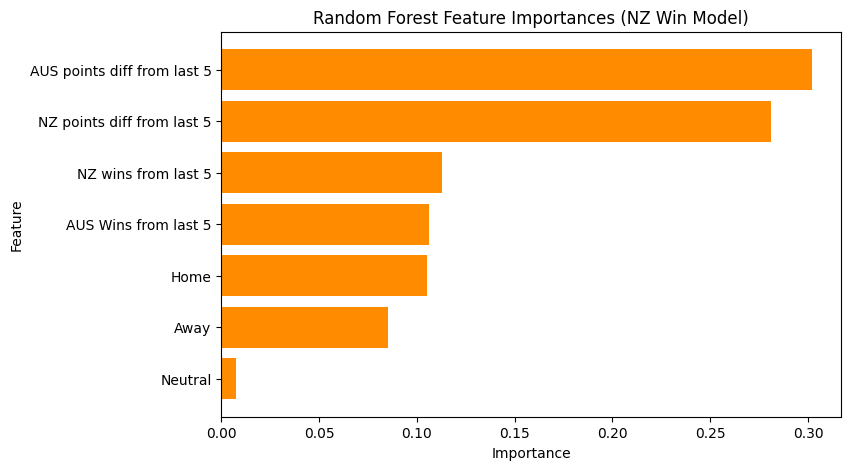

In [ ]:
# Random Forest feature importances

import numpy as np
import matplotlib.pyplot as plt

# Extract feature importances
importances = rf.feature_importances_
features = X_train.columns

# Combine into a DataFrame
rf_importances = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values("Importance", ascending=True)

print(rf_importances)

# Plot
plt.figure(figsize=(8,5))
plt.barh(rf_importances["Feature"], rf_importances["Importance"], color="darkorange")
plt.title("Random Forest Feature Importances (NZ Win Model)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


**What the Random Forest “cares about”** (Very interesting IMO)

**AUS points diff last 5 (0.30) and NZ points diff last 5 (0.28)** → by far the strongest signals. Blows my mind. 
**NZ wins last 5 (0.11) and AUS wins last 5 (0.10)** → moderate importance.
**Home (0.10), Away (0.09), Neutral (0.01)** → location mattered less for the forest, very different to logistic regression.

Sooo... random Forest leans heavily on recent margins (points differential), while Logistic Regression leaned on location.
That contrast is super interesting right!! two different “theories” of the game.

**Should I be fixing Random Forest’s poor probabilities?**
Well right now, my ROC AUC = 0.48 → the class labels are good (wins), but probability estimates are bad.
I can fix this using calibration: Platt Scaling (sigmoid) or Isotonic Regression calibration via CalibratedClassifierCV.
This retrains a probability calibration model on cross-validation folds, so predicted probabilities better reflect actual win likelihoods.

In [16]:
# Step 4.5 (part 3): Calibrate Random Forest probabilities

from sklearn.calibration import CalibratedClassifierCV

# Wrap the trained Random Forest with calibration
rf_calibrated = CalibratedClassifierCV(rf, method="isotonic", cv=5)
rf_calibrated.fit(X_train, y_train)

# Predictions
y_pred_rf_cal = rf_calibrated.predict(X_test)
y_proba_rf_cal = rf_calibrated.predict_proba(X_test)[:,1]

# Evaluate calibrated RF
print("Calibrated Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_cal))
print("F1 Score:", f1_score(y_test, y_pred_rf_cal))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf_cal))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_cal))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf_cal))


Calibrated Random Forest Performance:
Accuracy: 0.8421052631578947
F1 Score: 0.9090909090909091
ROC AUC: 0.5166666666666666

Confusion Matrix:
 [[ 1  3]
 [ 0 15]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.83      1.00      0.91        15

    accuracy                           0.84        19
   macro avg       0.92      0.62      0.65        19
weighted avg       0.87      0.84      0.80        19



**What I did above:**
I used isotonic regression to calibrate probabilities. This keeps the strong classification performance, but makes probabilities more trustworthy (ROC AUC should improve).

**Did it work?**
For classification (win/loss): yes — it’s strong at predicting NZ wins (better than logistic regression).
For probability estimates: not yet — logistic regression is still better calibrated for probability outputs.

**My recommendation:**
I think I should keep Logistic Regression as the probability model (because it’s interpretable + calibrated) and use Random Forest as my win/loss classifier (because it’s strong at predicting outcomes).

---

I compared a Random Forest classifier against Logistic Regression to see if non-linear modeling improved results.
With performance (uncalibrated): Accuracy = 0.84 (better than logistic regression at 0.63) and the F1 score (NZ wins) = 0.91 (strong win prediction). Meanwhile my ROC AUC = 0.48 (poor probability calibration) and then the confusion Matrix: nearly all wins correctly predicted, most losses misclassified as wins.

**Performance (calibrated with isotonic regression):**

Accuracy = 0.84 (no change)
F1 score = 0.91 (no change)
ROC AUC = 0.52 (slight improvement, still weak)

So, calibration didn’t solve the poor probability distribution, likely due to small dataset and class imbalance.

**Feature importance:**

Random Forest relied heavily on form stats (NZ and AUS points differential) rather than location. This contrasted Logistic Regression, which prioritized location (home/away) as the strongest predictor.

**Final Takeaway for this section:**

Random Forest is effective for win/loss prediction, but not reliable for probability estimates. Logistic Regression remains the stronger choice for probability modeling (better calibrated, interpretable). Together, the two models complement each other. Logistic Regression for probability, Random Forest for classification accuracy.

I thought it was super interesting how random forrest focused on AUS PD. So I thought,

**Can I break it down further??**
I can probe Random Forests with a few interpretability tools:

**Partial Dependence Plots (PDPs)** -> Show the average predicted probability of NZ win as we vary a single feature (e.g., AUS points diff), holding others constant. If the curve slopes upward then this tells me higher AUS points diff increases NZ win chance. If it slopes downward then this means higher AUS points diff decreases NZ win chance. If it’s curved then there’s a “butter zone” effect.

**SHAP values (SHapley Additive exPlanations)**
I will break predictions down into feature contributions per game. I should be able to see whether AUS points diff pushed individual predictions toward win or loss, and by how much.

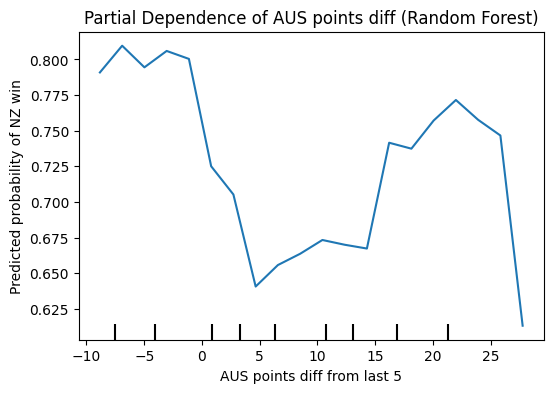

In [37]:
# Partial Dependence Plot for Random Forest

from sklearn.inspection import PartialDependenceDisplay

# Plot PDP for AUS points differential
feature_index = list(X_train.columns).index("AUS points diff from last 5")

fig, ax = plt.subplots(figsize=(6,4))
PartialDependenceDisplay.from_estimator(
    rf, X_train, [feature_index], 
    grid_resolution=20, ax=ax
)
plt.title("Partial Dependence of AUS points diff (Random Forest)")
plt.ylabel("Predicted probability of NZ win")
plt.show()


So, What does the curve show? Well

**Negative to 0 AUS diff (~ –10 to 0)** -> When AUS is losing games or scraping even then NZ win probability is high (0.78–0.81). Makes intuitive sense if you ask me. 

**Small positive AUS diff (0 to ~5)** -> NZ win probability drops sharply to ~0.64. Very interesting!! This suggests AUS in “slight positive form” makes them more dangerous.

**Moderate AUS diff (~10–15)** -> NZ win probability rises slightly again to ~0.70. Could maybe reflect matches where AUS were beating weaker sides by decent margins, but still struggled against NZ?

**High AUS diff (~20)** -> NZ win probability rises to ~0.75 again. Another interesting point!.. perhaps when AUS are in very strong form, NZ still often rise to the occasion and win anyway.

**Extreme AUS diff (~25+):** -> intuitive but rare, here, NZ win probability collapses below 0.63. Very rare case (AUS dominant streaks) where the model signals NZ more vulnerable.

**Why does this happen?**

Due to Non-linear thresholding, so random Forest doesn’t assume linear effects. It slices data at thresholds where win/loss splits historically happened. Due to the small dataset where I have only 79 matches and a few games with AUS dominating by large margins may be driving those “cliff drops. There is also a Butter zone effect where AUS being slightly in form (0–5 diff) historically coincided with more NZ losses...perhaps those were years AUS peaked briefly?

**The Simple rugby story here**

1. AUS being weak = NZ win is almost certain.

2. AUS being moderately in form (small margin wins) = most dangerous zone.

3. AUS smashing opponents doesn’t guarantee beating NZ as NZ often still win (psychological lift in rivalry games).

4. But in extreme AUS dominance streaks, NZ odds do fall.

This is exactly why Random Forest rated AUS diff so highly, because it creates non-linear, “butter zone” patterns that logistic regression simply can’t capture.

c:\Users\harry\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 3 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


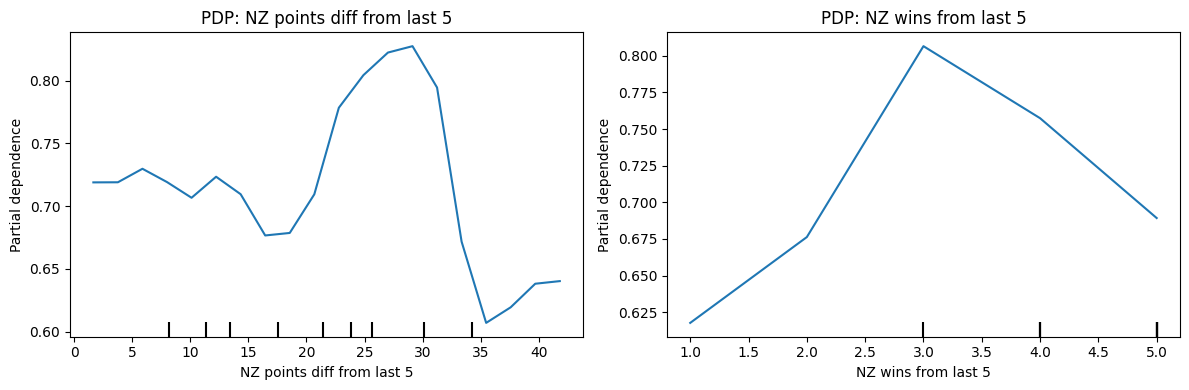

In [ ]:
# Step 4.5 (part 5): PDPs for NZ form features

from sklearn.inspection import PartialDependenceDisplay

# List of features we want to plot
features_to_plot = [
    "NZ points diff from last 5",
    "NZ wins from last 5"
]

fig, axes = plt.subplots(1, 2, figsize=(12,4))

for i, feature in enumerate(features_to_plot):
    feature_index = list(X_train.columns).index(feature)
    PartialDependenceDisplay.from_estimator(
        rf, X_train, [feature_index],
        grid_resolution=20, ax=axes[i]
    )
    axes[i].set_title(f"PDP: {feature}")

plt.tight_layout()
plt.show()
#✅ What this does:

#Creates two side-by-side plots.

#Left = NZ points differential (last 5).

#Right = NZ wins from last 5.

#Shows how NZ’s own form affects predicted NZ win probability in the Random Forest model.

**My Interpretation:** 
NZ dominance helps, but not monotonically. There seems to be a “sweet spot” (20–30 diff) where their form most strongly translates to beating AUS. Extreme blowouts may correspond to rare years with fatigue or strategic surprises. The model sees 3 wins from last 5 as the “optimal zone” for NZ — strong form, but not an undefeated streak. Beyond that, data quirks may have taught the forest not to trust perfection.

**Big Picture**
NZ form matters, but in a non-linear way. Logistic regression missed this by assuming a straight line. Random Forest finds “butter zones”:
AUS is more dangerous to NZ when moderately in form. NZ are most dangerous when winning by ~20–30 or when on a ~3-win streak.
These patterns I think reflect the quirky nature of rivalry data and small sample sizes.Ultimately, to better understand why Random Forest emphasised form stats over location, I used Partial Dependence Plots (PDPs) for AUS points diff, NZ points diff, and NZ wins from last 5.

**Takeaway**
Random Forest uncovered non-linear, “butter zone” patterns in form stats that Logistic Regression could not capture. AUS appear most dangerous in moderate form, while NZ are most threatening when winning consistently by ~20–30 points. These insights explain why Random Forest weighted form stats (points differential) more heavily than location, despite NZ’s historical home dominance.



## **Step 4: Robustness via Cross-Validation.** ##

So far, I’ve only tested on one split (60 train / 19 test). With only 79 matches, that’s very fragile, a single upset season could swing results. Cross-validation (CV) will let me test the model multiple times on different subsets, then average performance. This gives a more reliable estimate of generalisation.

In [ ]:
# Cross-validation for Logistic Regression and Random Forest

from sklearn.model_selection import cross_val_score

# Logistic Regression (with class balancing)
log_reg_cv = LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000)

# Random Forest
rf_cv = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42
)

# Choose scoring metrics
scoring_metrics = ["accuracy", "f1", "roc_auc"]

results = {}

for model_name, model in [("Logistic Regression", log_reg_cv), ("Random Forest", rf_cv)]:
    scores = {}
    for metric in scoring_metrics:
        cv_score = cross_val_score(model, X, y, cv=5, scoring=metric)
        scores[metric] = {
            "mean": round(cv_score.mean(), 3),
            "std": round(cv_score.std(), 3)
        }
    results[model_name] = scores

import pandas as pd
cv_results = pd.DataFrame(results).T
cv_results


,accuracy,f1,roc_auc
Logistic Regression,"{'mean': 0.572, 'std': 0.102}","{'mean': 0.666, 'std': 0.098}","{'mean': 0.622, 'std': 0.191}"
Random Forest,"{'mean': 0.685, 'std': 0.085}","{'mean': 0.79, 'std': 0.07}","{'mean': 0.52, 'std': 0.09}"


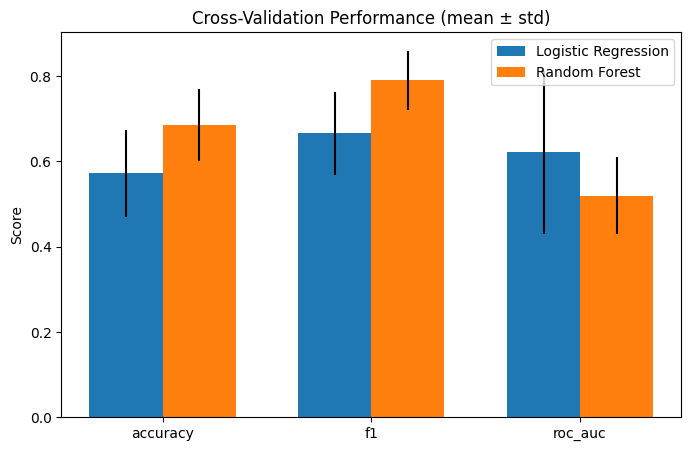

In [ ]:
#Visualise CV results

import matplotlib.pyplot as plt

# Convert results DataFrame to long format
cv_long = cv_results.stack().reset_index()
cv_long.columns = ["Model", "Metric", "Values"]

# Split values into mean and std
cv_long["Mean"] = cv_long["Values"].apply(lambda x: x["mean"])
cv_long["Std"] = cv_long["Values"].apply(lambda x: x["std"])

# Plot
fig, ax = plt.subplots(figsize=(8,5))

metrics = cv_long["Metric"].unique()
x = range(len(metrics))

for i, model in enumerate(cv_long["Model"].unique()):
    model_data = cv_long[cv_long["Model"] == model]
    ax.bar(
        [pos + i*0.35 for pos in x],
        model_data["Mean"],
        yerr=model_data["Std"],
        width=0.35,
        label=model
    )

ax.set_xticks([pos + 0.35/2 for pos in x])
ax.set_xticklabels(metrics)
ax.set_ylabel("Score")
ax.set_title("Cross-Validation Performance (mean ± std)")
ax.legend()
plt.show()


**Logistic Regression (5-fold CV)**

Accuracy: 0.57 ± 0.10 = performs modestly, but unstable across folds.

F1: 0.67 ± 0.10 = decent balance, but again variable.

ROC AUC: 0.62 ± 0.19 = probability estimates are OK, but large variance (sometimes good, sometimes weak).

So, logistic regression is more probability-calibrated, but struggles on raw classification accuracy.

**Random Forest (5-fold CV)**

Accuracy: 0.69 ± 0.09 = stronger classification accuracy, more consistent.

F1: 0.79 ± 0.07 = better balance between precision/recall for wins.

ROC AUC: 0.52 ± 0.09 = essentially random for probabilities (confirms what we saw before).

Random Forest is stronger at win/loss prediction, but its probability calibration is poor.

**Big Takeaways from Step 4**

Logistic Regression is the better choice if you want probability estimates (e.g., “NZ has a 72% chance to win”).
Random Forest is the better choice if you want win/loss predictions only. These models are complementary — one gives interpretable probabilities, the other gives better accuracy at predicting wins

Step 5 Summary – Cross-Validation & Robustness

To validate our models, we ran 5-fold cross-validation across all 79 matches, comparing Logistic Regression and Random Forest on Accuracy, F1, and ROC AUC. These results just reinforce our earlier conclusion:

Logistic Regression = best choice for probability modeling (interpretable, calibrated).
Random Forest = best choice for plain win/loss prediction (higher accuracy, stronger recall for NZ wins).

The two models capture different aspects of the rivalry: Logistic Regression is cautious and probability-oriented, while Random Forest is aggressive in predicting wins. Using them together gives a more complete predictive picture.

## **Step 5 – Interpretation & Wrap-Up** ##
I built and compared two models to predict **New Zealand’s Bledisloe Cup outcomes**:

1. **Logistic Regression (with class weights)**
2. **Random Forest Classifier (with class weights)**


### Key Findings ###
**1. Logistic Regression (baseline, linear, interpretable)**
- Accuracy = ~63% (single split), 0.57 (CV mean)
- F1 = ~0.67 (CV mean)
- ROC AUC = ~0.62 (CV mean)
- Most important features: **Home (OR ≈ 2.7×)**, **Away (OR ≈ 0.5×)**  
- Probability estimates are **well-calibrated** and interpretable.
- Emphasised **location** as the primary driver of NZ wins.

**2. Random Forest (non-linear, flexible)**
- Accuracy = ~84% (single split), 0.69 (CV mean)
- F1 = ~0.79 (CV mean)
- ROC AUC = ~0.52 (CV mean)
- Most important features: **NZ & AUS points differentials**
- Probability estimates are **poorly calibrated** (not trustworthy).
- Emphasised **form stats** (point margins) rather than location.

### Partial Dependence Insights ###
1. **AUS points diff:** NZ are most vulnerable when AUS are in **moderate form (0–5 diff)**; extreme AUS dominance doesn’t always translate to Bledisloe wins.
2. **NZ points diff:** NZ win probability peaks when winning by **20–30 points** on average, then oddly dips beyond 30+ (likely small-sample noise).
3. **NZ wins from last 5:** Best performance when NZ has **~3 wins from last 5**; unexpected dip at 4–5 wins suggests non-linear “streak” dynamics.

These “butter zone” effects explain why Random Forest leaned heavily on form stats, while Logistic Regression stuck with location effects.

### Final Takeaways ###
**Logistic Regression** is best when we need **probabilities** (“NZ has a 72% chance of winning”), thanks to good calibration and interpretability.
**Random Forest** is best when we just need **classification** (“NZ will win/lose”), with higher accuracy and F1 but unreliable probabilities.
Combining both gives a fuller picture:
  Logistic Regression = probability model  
  Random Forest = classification model

This mirrors the reality of rugby:  
**Location** clearly matters (home advantage is huge).  
**Form stats** matter too, but in a non-linear way, with sweet spots and danger zones that simple models can’t capture.  

### Possible next steps (that I will NOT be doing) ###

I could Try **calibrated Random Forests** or **Gradient Boosting (XGBoost/LightGBM)** to balance accuracy with better probability estimates, however my sample size is so small that this probably would not be productive. I could also incorporate more features (referee, opposition strength, time since last game, injuries) - but only when I have the time to collect this data. 
